# Lab 2 - Local Clusters

This notebook introduces some local clusters methods such as the local neighbor match test and density-based clustering.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will begin this exercise reviewing the Neighbor Match Test. The Neighbor Match Test is an alternative approach to visualize and quantify the trade off between geographical and attribute similarity as suggested by Anselin and Li (2020). The basic idea is to assess the extent of overlap between k-nearest neighbors in geographical space and k-nearest neighbors in multi-attribute space.

The functionality will be illustrated using the Chicago SDOH sample data set. It contains observations on socio-economic determinants of health in 2014 for 791 census tracts in Chicago. It can be downloaded from https://geodacenter.github.io/data-and-lab/Chi-SDOH/


In the second part of this notebook, we will review density-based clustering methods such as the DBscan and HDBscan. For this part, we will use the two data sets from our previous notebook. The first is the **Liquor** sample data set that contains the location of the liquor stores in Chicago, IL. This data was scraped from Google Maps in 2015 and contains 2 variables and 571 observations. Available at: https://geodacenter.github.io/data-and-lab/liq_chicago/ . The second is the Chicago Community Area Population and Percent Change for 2000 and 2010. It is based on 77 observations and 8 variables. Available at: https://geodacenter.github.io/data-and-lab/commpop/.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the following specification:

In addition to these packages, for the Neighbor Match Test we will also need **pygeoda**, a python library for spatial data analysis developed by Xun Li and Luc Anselin. For more information on the library, please check https://geodacenter.github.io/pygeoda/index.html . If not already installed, the library can be installed running `pip install pygeoda` from your terminal or notebook. To make sure you have the latest version, use `pip install -U pygeoda`.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pygeoda 
from sklearn.cluster import DBSCAN, HDBSCAN
from spatial_cluster_course import cluster_map


## Neighbor Match Test

As shown in Anselin (2023) (section 18.5, https://lanselin.github.io/introbook_vol1/localneighbormatch.html), the Neighbor Match Test is based on an intersection operation between two k-nearest neighbor weights matrices. One matrix is derived from the distances in multi-attribute space, the other using geographical distance. With the intersection in hand, the probability that an overlap occurs between the two neighbor sets can be quantified. This corresponds to the probability of drawing $v$ common neighbors from the $k$ out of $n−1−k$ possible choices as neighbors, a straightforward combinatorial calculation.

More formally, the probability of $v$ shared neighbors out of $k$ is: 

$p=C(k,v).C(N−k,k−v)/C(N,k),$

where $N=n−1$ (one less than the number of observations), $k$ is the number of nearest neighbors considered in the connectivity graphs, $v$ is the number of neighbors in common, and $C$ is the combinatorial operator. 

### Load data

The following files will be used to compute the Neighbor Match Test:
- **Chi-SDOH.shp,shx,dbf,prj**: shape file (four files) for 791 census tracts

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
chi_sdoh = gpd.read_file(path+"Chi-SDOH/Chi-SDOH.shp")
print(chi_sdoh.shape)
chi_sdoh.head(3)

(791, 56)


,OBJECTID,Shape_Leng,Shape_Area,TRACTCE10,geoid10,commarea,ChldPvt14,EP_CROWD,EP_UNINSUR,EP_MINRTY,...,ForclRt,EP_MUNIT,EP_GROUPQ,SchHP_Mi,BrownF_Mi,card,cpval,COORD_X,COORD_Y,geometry
0,1,22777.477721,2.119089e+07,842400.0,1.703184e+10,44.0,30.2,2.0,18.6,100.0,...,0.0,6,0.0,0.323962,0.825032,0.0,0.0,1176.183467,1849.533205,"POLYGON ((1177796.742 1847712.428, 1177805.261..."
1,2,16035.054986,8.947394e+06,840300.0,1.703184e+10,59.0,38.9,4.8,25.2,85.9,...,0.0,2,0.0,2.913039,0.833580,0.0,0.0,1161.787888,1882.078567,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
2,3,15186.400644,1.230614e+07,841100.0,1.703184e+10,34.0,40.4,4.9,32.1,95.6,...,0.0,42,0.1,1.534987,0.245875,0.0,0.0,1174.481923,1889.069999,"POLYGON ((1176041.55 1889791.988, 1176042.377 ..."


The `neighbor_match_test` function from **pygeoda** requires three arguments: 

- geoda_obj (geoda): An instance of geoda class
- data (list or dataframe): A list of numeric vectors of selected variable or a data frame of selected variables
- k (int): A positive integer number for k-nearest neighbors searching.

The geoda_obj will be the dataframe we have already loaded, converted to a geoda class object.

For this exercise, we will select three variables as data: the percentage children in poverty in 2014 (`ChldPvt14`), a crowded housing index (`EP_CROWD`), and the percentage without health insurance (`EP_UNINSUR`).

In addition to the variable names, we need to specify the number of neighbors, i.e., the value of k in the k-nearest neighbor weights that are computed under the hood. In the example, 12 is used. 

Additional arguments that can be privided to the function are:

- scale_method (str, optional): One of the scaling methods {'raw', 'standardize', 'demean', 'mad', 'range_standardize', 'range_adjust'} to apply on input data. Default is 'standardize' (Z-score normalization).
- distance_method (str, optional): The type of distance metrics used to measure the distance between input data. Options are {'euclidean', 'manhattan'}. Default is 'euclidean'.
- power (float, optional): The power used in an inverse distance calculation, default is 1.0.
- is_inverse (bool, optional): FALSE (default) or TRUE, apply inverse on distance value.
- is_arc (bool, optional): FALSE (default) or TRUE, compute arc distance between two observations.
- is_mile (bool, optional) TRUE (default) or FALSE, convert distance unit from mile to km.

In [3]:
chi_sdoh_g = pygeoda.open(chi_sdoh)
data = chi_sdoh_g[['ChldPvt14','EP_CROWD','EP_UNINSUR']]
nmt = pygeoda.neighbor_match_test(chi_sdoh_g, data, 12)
print(nmt.keys())

dict_keys(['Cardinality', 'Probability'])


The function returns a dictionary with the cardinality and its associated probability. The cardinalities indicate how many neighbors the two weights matrices have in common. Different p-value cut-offs can be employed to select the significant locations, i.e., where the probability of a given number of common neighbors falls below the chosen p.

We can use matplotlib to plot these cardinalities to visualize the locations of interest.

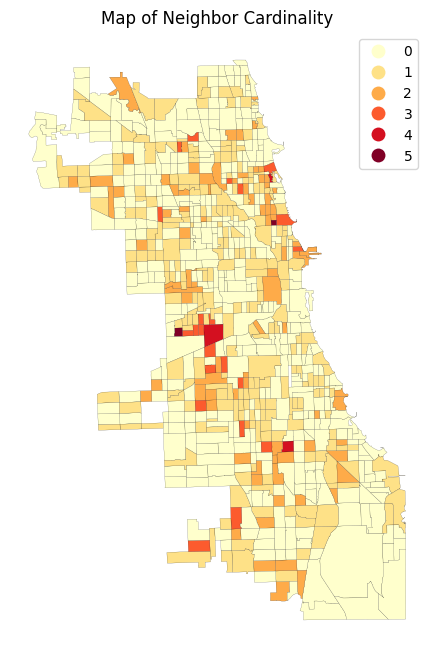

In [4]:
chi_sdoh['Cardinality'] = nmt['Cardinality']

fig, ax = plt.subplots(figsize=(8, 8))

chi_sdoh.plot(column='Cardinality', 
              ax=ax, 
              legend=True, 
              categorical=True, 
              cmap='YlOrRd', 
              edgecolor='black',
              linewidth=0.1)  

ax.set_title("Map of Neighbor Cardinality")
ax.set_axis_off()
plt.show()


The matches range from 1 to 5 (out of a possible 12). There are three locations with four matches and two locations with five matches. Five matches is extremely rare, with a p-value less than 0.0000001. Four matches has a p-value less than 0.000014.

## Density-based clustering

In this section, we review the following methods: DBscan and HDBscan.

### Load data

For this exercise, we will use the location of the liquor stores in Chicago, IL, as provided by the GeoDa data repository from the Center of Spatial Data Science (University of Chicago). This data was scraped from Google Maps in 2015 and contains 2 variables and 571 observations. Available at: https://geodacenter.github.io/data-and-lab/liq_chicago/


In [6]:
point_df = gpd.read_file(path+"liquor/liq_Chicago.shp")
point_df.head(3)

,id,placeid,geometry
0,0,ChIJnyLZdBTSD4gRbsa_hRGgPtc,MULTIPOINT (1161395.91 1928443.285)
1,3,ChIJ5Vdx0AssDogRVjbNIyF3Mr4,MULTIPOINT (1178227.792 1881864.522)
2,4,ChIJb5I6QwYsDogRe8R4E9K8mkk,MULTIPOINT (1178151.911 1879212.002)


We will also use Chicago's Communities Areas shape just for better visualization of our point data information. The methods used in this exercise rely only on the distance between the points. For simplicity, let's keep only the ID variable from the shapefile, and the polygon's geometries.

In [7]:
chi_comm = gpd.read_file(path+"chicago_commpop/chicago_commpop.shp")
chi_comm.head(3)

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."


Here we will plot the data to verify whether everything seems to be OK. Keep in mind that since we will overlap two different shapefiles, we must make sure they have the same projection. To that extent, we use `to_crs` to convert the projection of the community area file to that of the point file.

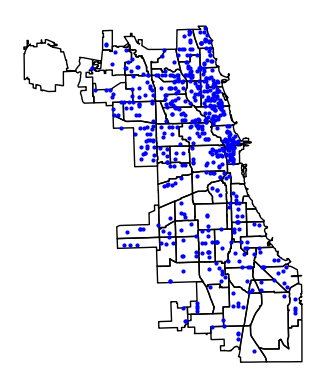

In [8]:
# Converting the projection of the community areas shape to the same as the liquor store shape:
chi_comm = chi_comm.to_crs(point_df.crs)

# Plotting the figure with both layers:
fig, ax = plt.subplots()
chi_comm.plot(ax=ax, color='none', edgecolor='black') 
point_df.plot(ax=ax, markersize=4, color='blue')
ax.set_axis_off()
plt.show()

## A Quick Introduction to scikit-learn

The most comprehensive Python library for classical machine learning is scikit-learn, imported as `sklearn`. Among its wide range of functionality, it supports many methods for so-called unsupervised learning, which includes all clustering techniques. In our notebooks, we will be using scikit-learn for all classic non-spatial clustering methods, included in the `sklearn.cluster` module. However, spatially constrained clustering is not included. For the latter methods, we will continue to rely on `pygeoda`, which contains a subset of the clustering functionality in GeoDa desktop. The complete user guide for scikit-learn can be found at https://scikit-learn.org/stable/user_guide.html.

Scikit-learn can be a bit overwhelming at first. Also, the interface may seem a bit strange, but it is fully consistent throughout (not a mean feat when supporting so many different methods), and after a while it will become more familiar. For our purposes, we can get away with only some basic knowledge. 

The distinguishing characteristic of the design is that it is fully object oriented. Each type of clustering is represented by a class, which needs to be instantiated, i.e., a specific object of that class is generated. The class supports a range of methods and creates attributes. The main method, common to all classes in scikit-learn, is `fit`. In essence, this applies the clustering algorithm. The results are available as attributes of the object. For example, for all the clustering methods considered in scikit-learn, this is the attribute `labels_` (don't forget the underline), a simple numpy array with a label for each observation. It is then up to you to translate this into meaningful information, such as a cluster map. It is also important to remember that all input to scikit-learn consists of numpy arrays, not pandas data frames. This typically requires some additional work up front to get the data into the proper format.

Later we will also see how `sklearn.preprocessing` supports a range of data transformations, including standardization. However, here we only consider clustering of point data, which should **not** be standardized. We return to the topic of standardization in a later notebook.

## DBSCAN

This section uses DBSCAN to find clusters in the data. As presented in Anselin (2023 - https://lanselin.github.io/introbook_vol1/dbscan.html), "the DBSCAN algorithm was originally outlined in Ester et al. (1996) and Sander et al. (1998), and was more recently elaborated upon in Gan and Tao (2017) and Schubert et al. (2017)".

DBSCAN requires a definition for Eps and MinPts. Eps refers to the Epsilon, the critical distance band that works similarly to a uniform kernel function as the area in which the frequency of points will be assessed. MinPts is the minimum number of points within the critical distance band to consider the spatial distribution to be dense. MinPts includes center point, i.e. MinPts = 4 implies one point with 3 neighbors.

To run DBSCAN clustering on our data, we will use the DBSCAN functionality from `sklearn.cluster`. Full details can be found at
https://scikit-learn.org/stable/modules/clustering.html#dbscan.

As mentioned, we first need to turn the input into the right format. DBSCAN expects the coordinates of each point as a 2-column numpy array, so we need convert that information from the geodataframe to a new numpy array.

In [9]:
# Storing the coordinates of each point as a 2-column numpy array as expected by the DBSCAN function:
liq_coords_array = np.vstack([point_df.centroid.x, point_df.centroid.y]).T
liq_coords_array

array([[1161395.91025926, 1928443.28534456],
       [1178227.79209592, 1881864.5220016 ],
       [1178151.91115887, 1879212.00187958],
       ...,
       [1171549.19909224, 1915176.27935293],
       [1184001.30025116, 1852764.17898194],
       [1165614.11122558, 1930579.92456581]])

### Main Call

In DBSCAN, `eps` is the argument to inform the **Eps** and `min_samples` is the argument to inform the **MinPts**. A cluster object is instantiated by means of `DBSCAN` to which these arguments are passed (note that we can apply `DBSCAN` directly since `sklearn.cluster` was imported, which provides direct access to all the clustering methods). The second step is to apply the `fit` method to this object. This requires the numpy array with coordinates.

In the example, we use eps=3000 and min_samples=10. The result contains a large number of attributes (and methods), illustrated by means of `dir`. We are only interested in the attribute `labels_`, which contains the clustering designation of each of our liquor store points. 

In the output below, we see that `db_results` is an instance of the `DBSCAN` class, `db_results.labels_` is a numpy array that contains seven different labels, with -1 for so-called **noise** points.

In [10]:
# Function DBSCAN is used to fit the clustering method to the coordinates of our liquor stores, with set values
# for Eps and MinPts:
db_results = DBSCAN(eps=3000, min_samples=10)
db_results = db_results.fit(liq_coords_array)
# the result is an instance of class DBSCAN
print(type(db_results))
# it contains many methods and attributes
print(dir(db_results))
# the cluster labels
print(type(db_results.labels_))
# a brief summary of the cluster categories
totclust,clustcount = np.unique(db_results.labels_,return_counts=True)
print(totclust)
print("number of different cluster categories (noise points included): ", len(totclust))
print("cluster member size: ",clustcount)

<class 'sklearn.cluster._dbscan.DBSCAN'>
['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', '_validate_params', 'algorithm', 'components_', 'core_sample_indices_', 'eps', 'fit', 'fit_predict', 'get_metadata_routing', 'get_params', 'labels_', 'leaf_s

### Cluster statistics

We can create a small data frame that lists the labels for each cluster and the number of observations that belong to them. Recall that noise points are labeled as -1. We put this in a small helper function that we can reuse for all future cluster methods, since scikit-learn will consistently put the cluster labels in the `labels_` attribute.

In [11]:
def cluster_stats(clustlabels):
    """
    Creates a data frame with cluster labels and cardinality

    Arguments
    ---------
    clustlabels     : cluster labels from a scikit-learn cluster class

    Returns
    -------
    clustframe      : a pandas dataframe with columns Labels and Cardinality

    """
    totclust,clustcount = np.unique(clustlabels,return_counts=True)
    cl = np.array((totclust,clustcount)).T
    clustframe = pd.DataFrame(data=cl,columns=["Labels","Cardinality"])
    return(clustframe)

We can now apply this to the output of our DBSCAN application. The results shows 310 out of the 571 observations classified as noise. Unlike what holds for the GeoDa clustering methods, the cluster labels are given in no particular order (in GeoDa, they are sorted by size).

In [12]:
print(cluster_stats(db_results.labels_))

   Labels  Cardinality
0      -1          310
1       0           75
2       1          110
3       2           35
4       3           13
5       4           16
6       5           12


### Cluster map

The results of a cluster exercise are best visualized in a so-called cluster map. Again, to save us time later, we use a small helper function from the `spatial_cluster_class` module to create a categorical point map for the cluster labels, overlaid on a background boundary file. In our example, we use the Chicago community areas. Note that this assumes that the point and area layers are in the same projection (there is no check), which we made sure of above.

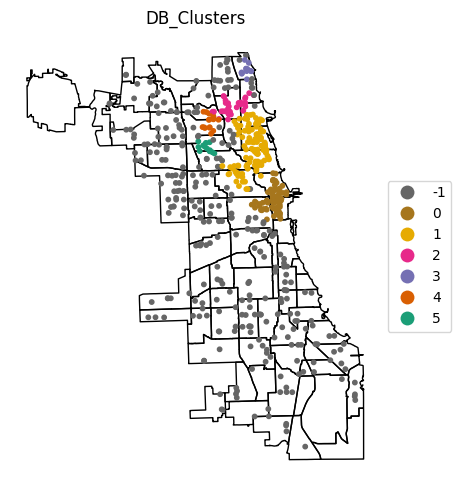

In [14]:
cluster_map(point_df,db_results.labels_,title="DB_Clusters",baselayer=chi_comm,cmap='Dark2_r')

### Sensitivity analysis

The results of DBSCAN are very sensitive to the choice of Eps and MinPts. Try changing each of these parameters in the DBSCAN function to see how it affects the resulting clusters. Below, we set eps=8000 and min_samples=4. Note how we now combine the instantiation of the DBSCAN class with the `fit` method in one line.

The result is quite different, with only two clusters identified, of which one contains 561 observations (out of 571) and there are only 3 noise points.

   Labels  Cardinality
0      -1            3
1       0          561
2       1            7


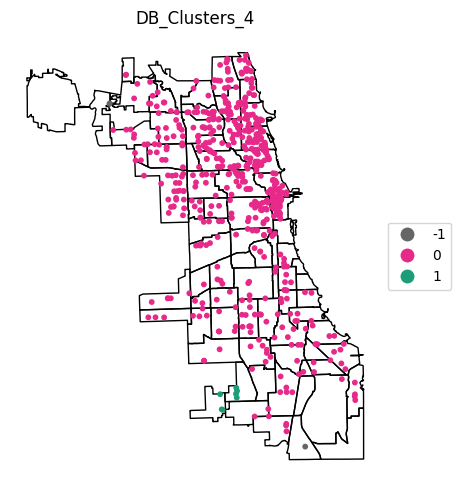

In [15]:
db_results = DBSCAN(eps=8000, min_samples=4).fit(liq_coords_array)
print(cluster_stats(db_results.labels_))
cluster_map(point_df,db_results.labels_,title="DB_Clusters_4",baselayer=chi_comm,cmap='Dark2_r')

## HDBSCAN

This section uses HDBSCAN to find clusters in the data. HDBSCAN requires only the definiton of the minimum number of points in a neighborhood for a given point to be considered as a core point. The minimum number of points in any cluster will, by default, assume the same value.

As presented in Anselin ((2023) - https://lanselin.github.io/introbook_vol1/HDBSCAN.html), "HDBSCAN was originally proposed by Campello, Moulavi, and Sander (2013), and more recently elaborated upon by Campello et al. (2015) and McInnes and Healy (2017). As in DBSCAN*, the algorithm implements the notion of mutual reachability distance. However, rather than applying a fixed value of the cut-off distance to produce a cluster solution, a hierarchical process is implemented that finds an optimal cluster combination, using a different critical cut-off distance for each cluster. In order to accomplish this, the concept of cluster stability or persistence is introduced. Optimal clusters are selected based on their relative excess of mass value, which is a measure of their persistence".

This algorithm is implemented in the `HDBSCAN` class of `sklearn.cluster`. To instantiate an object of this class, the only required argument is the `min_cluster_size`, the minimum number of points in a neighborhood. As before, we apply the `fit` method with as argument the numpy array of point coordinates. As mentioned, all cluster classes in scikit-learn contain the cluster labels in the `labels_` attribute.

We illustrate this using `min_cluster_size=10`. We combine the class instantiation and `fit` method in one line and reuse our `cluster_stats` and `cluster_map` functions to summarize the results.

The results are quite reasonable, yielding five clusters with sizes ranging from 14 to 181, as well as 220 noise points. As in the DBSCAN case, some experimentation with different parameter settings is highly recommended.

   Labels  Cardinality
0      -1          220
1       0           55
2       1           23
3       2           78
4       3          181
5       4           14


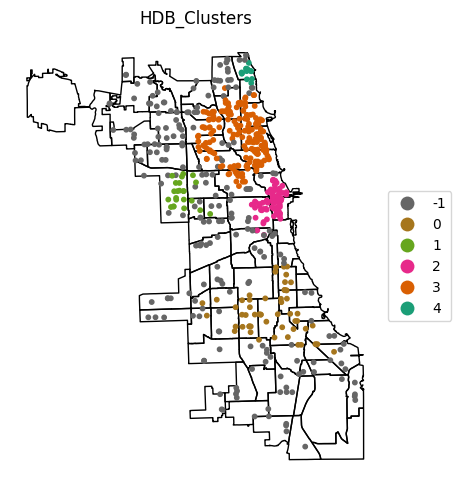

In [16]:
# Function HDBSCAN is used to fit the clustering method to the coordinates of our liquor stores, with set value
# for min_cluster_size:
hdb_results = HDBSCAN(min_cluster_size=10).fit(liq_coords_array)
print(cluster_stats(hdb_results.labels_))
cluster_map(point_df,hdb_results.labels_,title="HDB_Clusters",baselayer=chi_comm,cmap='Dark2_r')

## Practice

Use your own data set or one of the GeoDa Center or PySAL sample data sets to load a multivariate data file or point data file. In case of the first, compute the Neighbor Match Test and assess the impact of varying number of neighbors. In case of point data, compare the results between DBscan and HDBscan, and assess the impact of chaning the relevant parameters.